# The Product Pricer with Frontier Models

In [1]:
## imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
from testing import Tester
%matplotlib inline

In [2]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')

In [3]:
openai = OpenAI()
claude = Anthropic()

In [4]:
## Load already processed train and test sets
with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
test[0].prompt

"How much does this cost to the nearest dollar?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color\n\nPrice is $66.00"

## 01) GPT-4o-mini

In [6]:
## Some additional data preprocessing steps
# Removing the " to the nearest dollar" and "Price is $" context

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [7]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color"

In [8]:
## A utility function to extract the price from a string
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [9]:
get_price("The price is roughly $60")

60.0

In [19]:
def gpt_model_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42, ## Used to generate same answer in upcoming runs
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 Item: Setpower Insulated Protective Cover for ...
2: Guess: $10.99 Truth: $9.68 Error: $1.31 SLE: 0.01 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $129.99 Truth: $155.98 Error: $25.99 SLE: 0.03 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $15.99 Truth: $5.59 Error: $10.40 SLE: 0.90 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $30.00 Truth: $98.40 Error: $68.40 SLE: 1.36 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $35.99 Truth: $54.99 Error: $19.00 SLE: 0.17 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $10.99 Truth: $5.71 Error: $5.28 SLE: 0.34 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $10.99 Truth: $9.53 Error: $1.46 SLE: 0.02 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $14.99 Truth: $11.24 Error: $3.75 SLE: 0.07 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $29.99 Truth: $12.88 Error: $17.11 SLE: 0.65 Item: Away NV350 

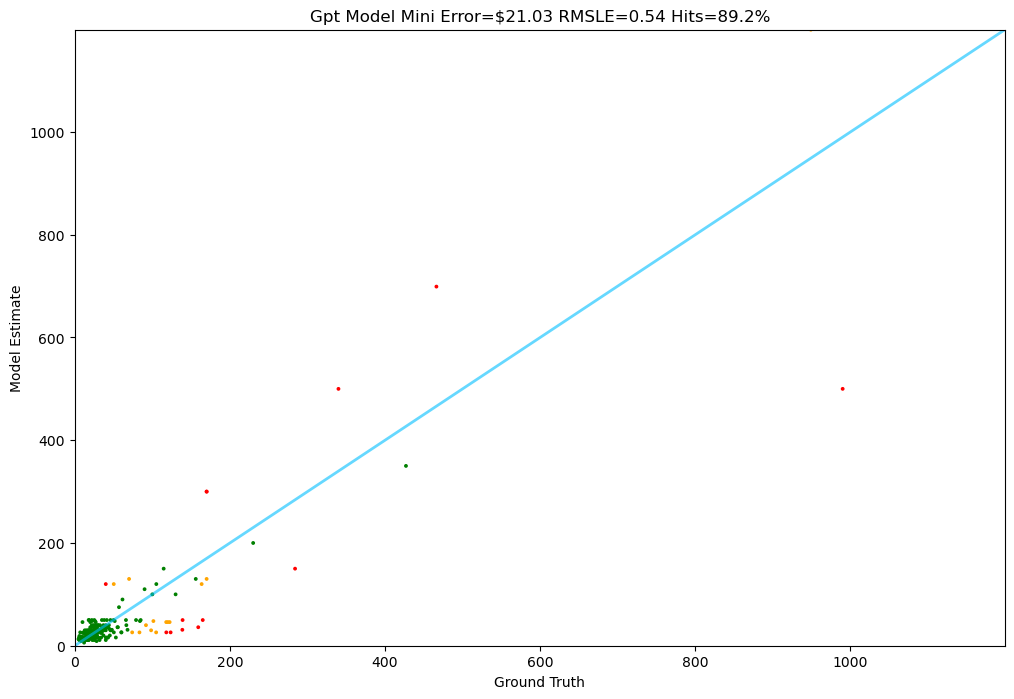

In [21]:
Tester.test(gpt_model_mini, test)

## 02) gpt-4.1-2025-04-14

In [10]:
def gpt_41_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4.1-2025-04-14", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 Item: Setpower Insulated Protective Cover for ...
2: Guess: $7.99 Truth: $9.68 Error: $1.69 SLE: 0.03 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $98.00 Truth: $155.98 Error: $57.98 SLE: 0.21 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $8.99 Truth: $5.59 Error: $3.40 SLE: 0.17 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $60.00 Truth: $98.40 Error: $38.40 SLE: 0.24 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $59.99 Truth: $54.99 Error: $5.00 SLE: 0.01 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $5.00 Truth: $5.71 Error: $0.71 SLE: 0.01 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $11.99 Truth: $9.53 Error: $2.46 SLE: 0.04 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $16.99 Truth: $11.24 Error: $5.75 SLE: 0.15 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $14.99 Truth: $12.88 Error: $2.11 SLE: 0.02 Item: Away NV350 NV351 NV

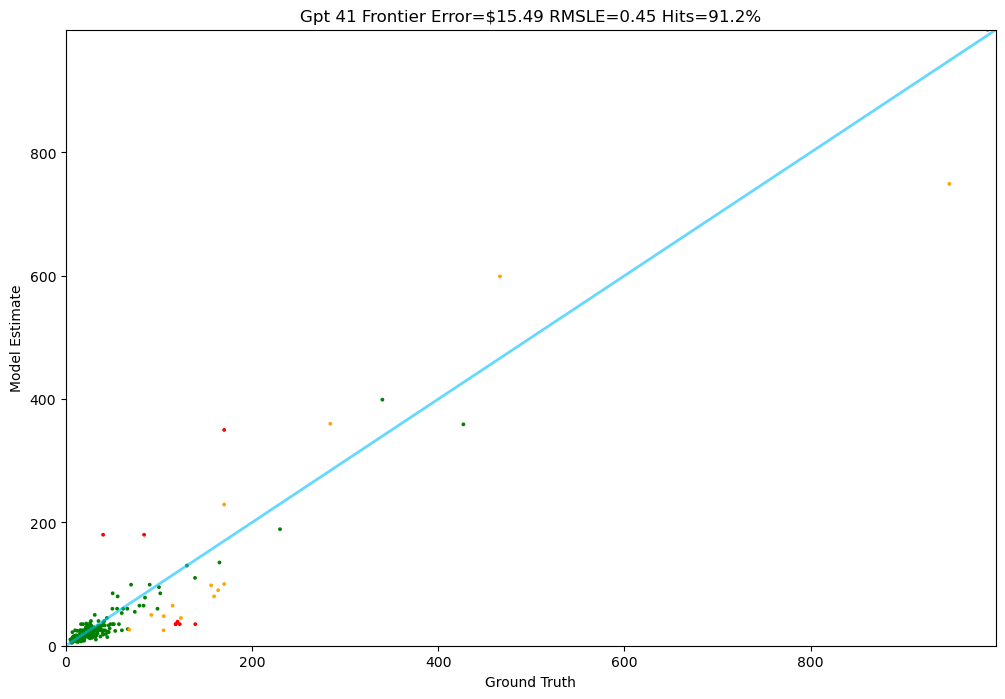

In [11]:
Tester.test(gpt_41_frontier, test)

## 03) Claude-opus-4-1-20250805

In [12]:
def claude_opus_4_1(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-opus-4-1-20250805",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $32.99 Truth: $65.99 Error: $33.00 SLE: 0.46 Item: Setpower Insulated Protective Cover for ...
2: Guess: $10.00 Truth: $9.68 Error: $0.32 SLE: 0.00 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $110.00 Truth: $155.98 Error: $45.98 SLE: 0.12 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $8.99 Truth: $5.59 Error: $3.40 SLE: 0.17 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $158.99 Truth: $98.40 Error: $60.59 SLE: 0.23 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $20.00 Truth: $54.99 Error: $34.99 SLE: 0.96 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $3.99 Truth: $5.71 Error: $1.72 SLE: 0.09 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $18.75 Truth: $9.53 Error: $9.22 SLE: 0.40 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $8.99 Truth: $11.24 Error: $2.25 SLE: 0.04 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $19.99 Truth: $12.88 Error: $7.11 SLE: 0.17 Item: Away NV350 NV35

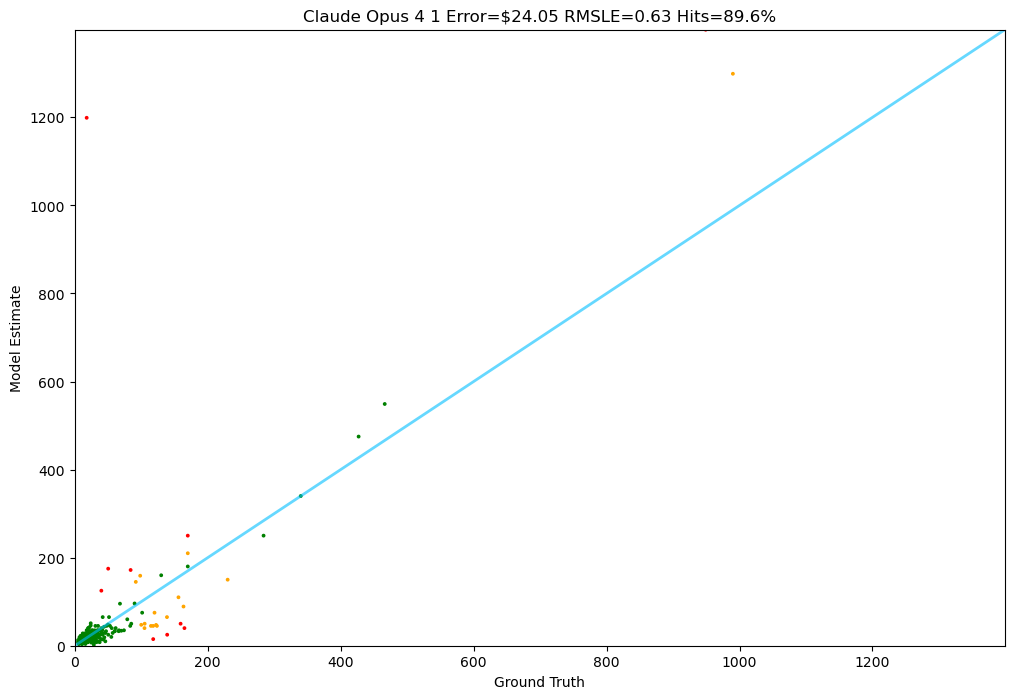

In [13]:
Tester.test(claude_opus_4_1, test)